This is a LSTM forecasting for "RUB/USD", "Oil", "Gas", and "MOEX" indexies. As was previously analysed (Johnson, Jaya. 2023. Machine Learning for Financial Market Forecasting. Master's thesis, Harvard University Division of Continuing Education.) a LSTM-based forecasting is not accurate, and SVM and traditional technical analysis overpower.

MOEX is one of the central indexies, it describes the country's market. It depends on the prices of gas and oil, as well as the ruble exchange rate.

Economics is irrational, it also depends on psychology. Therefore, it is better to use technical analysis in the intervals between major events, and include fundamental analysis in the case of extraordinary ones. And this is still a probabilistic scenario.

Here is a neural network consisting of LSTM blocks with a different number of hidden parameters. The analysis is carried out over a 40-day window (2 working months, the range is taken from the technical analysis). In my subjective opinion, this setting showed the best. Again, this is purely my subjective opinion.

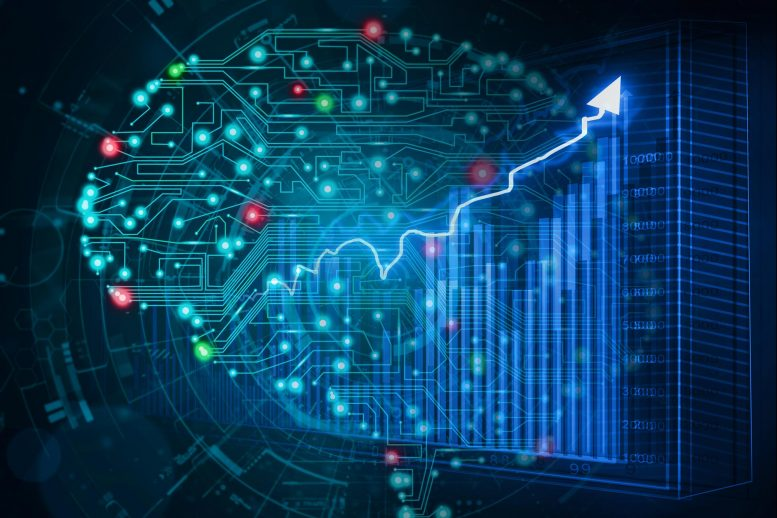

Import libraries

In [ ]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn

import random
import torch

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_random_seed(42)

In [ ]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 12.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 65.3 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.6-cp310-cp310-linux_x86_64.whl size=728059 sha256=d8ea7b2dae2546ac51cf76465a7459260e41f87c43a6647b8d97ac72dcf1f969
  Stored in directory: /root/.cache/pip/wheels/4b/b9/b0/83d6e258e8f963f5ff111a2cd8c483ca59372a86e6a2535212
Successfully built peewee


Import yfinance

In [ ]:
# To fetch financial data
import yfinance as yf

Choose the periods and check the data

In [ ]:
period = '10y'
interval = '1d'

In [ ]:
# Set the ticker as 'RUB=X=X'
forex_data = yf.download('RUB=X', period=period, interval=interval)

# Set the index to a datetime object
forex_data.index = pd.to_datetime(forex_data.index)

# Display the last five rows
forex_data.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-08-13,90.998436,93.747124,90.975548,90.995522,90.995522,0
2024-08-14,90.493446,92.997658,88.001091,90.496338,90.496338,0
2024-08-15,89.795944,90.488571,88.243538,89.795135,89.795135,0
2024-08-16,88.915459,89.497574,87.745506,88.921532,88.921532,0
2024-08-17,89.225998,89.425003,89.225998,89.425003,89.425003,0


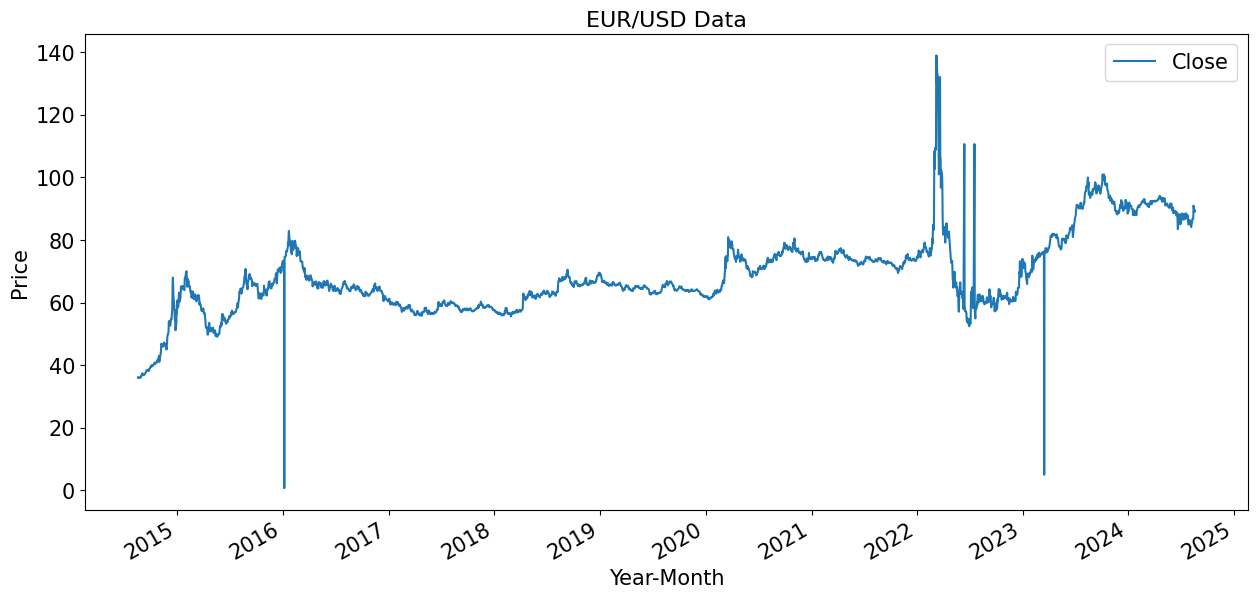

In [ ]:
# Plot the close price
plt.figure(figsize=(15, 7))
forex_data['Close'].plot()

# Set the title and axis label
plt.title('EUR/USD Data', fontsize=16)
plt.xlabel('Year-Month', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['Close'], prop={'size': 15})

# Show the plot
plt.show()

In [ ]:
forex_data[(forex_data['Close']>100)|(forex_data['Close']<30)]['Close']

,Close
Date,
2016-01-06,0.716200
2022-03-01,104.973503
2022-03-02,108.479500
2022-03-03,102.714996
2022-03-04,109.464996
2022-03-07,108.845100
2022-03-08,138.965103
2022-03-09,129.964996
2022-03-10,138.714996


In [ ]:
forex_data.loc['2022-06-13','Close'] = (forex_data.loc['2022-06-10','Close']+forex_data.loc['2022-06-14','Close'])/2
forex_data.loc['2022-06-13','Close']

57.84000015258789

In [ ]:
forex_data.loc['2022-07-18','Close'] = (forex_data.loc['2022-07-15','Close']+forex_data.loc['2022-07-19','Close'])/2
forex_data.loc['2022-07-18','Close']

57.977500915527344

In [ ]:
forex_data.loc['2023-03-16','Close'] = (forex_data.loc['2023-03-15','Close']+forex_data.loc['2023-03-17','Close'])/2
forex_data.loc['2023-03-16','Close']

76.08999633789062

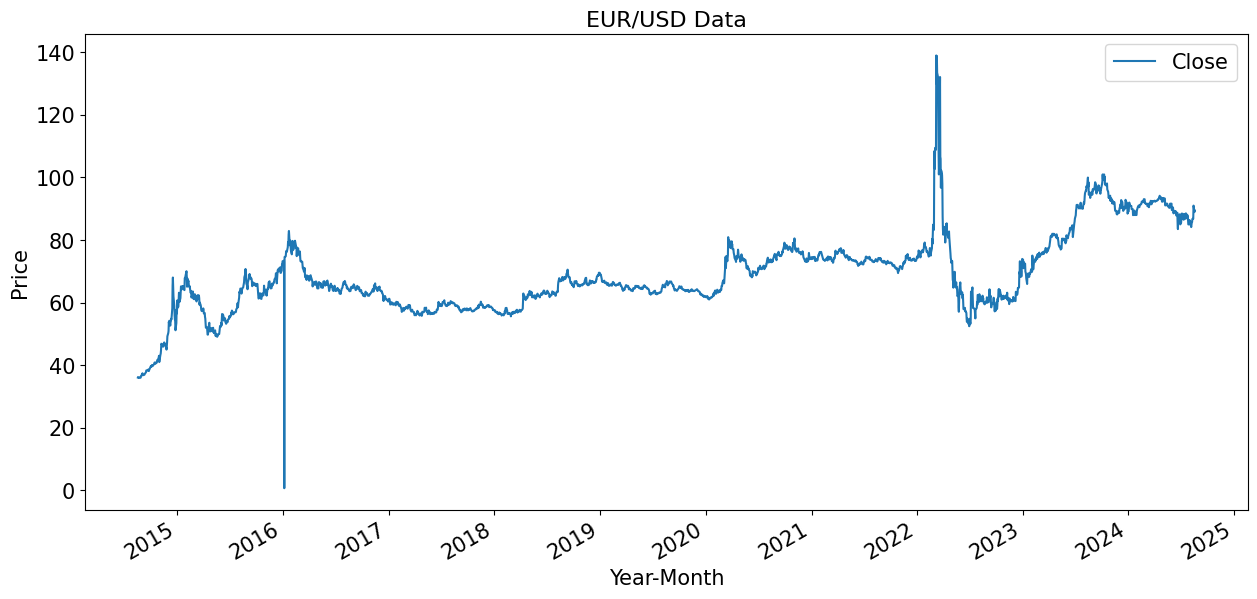

In [ ]:
# Plot the close price
plt.figure(figsize=(15, 7))
forex_data['Close'].plot()

# Set the title and axis label
plt.title('EUR/USD Data', fontsize=16)
plt.xlabel('Year-Month', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['Close'], prop={'size': 15})

# Show the plot
plt.show()

In [ ]:
forex_data_1 = yf.download('BZ=F', period=period, interval=interval)

# Set the index to a datetime object
forex_data_1.index = pd.to_datetime(forex_data_1.index)

# Display the last five rows
forex_data_1.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-08-12,79.669998,82.400002,79.480003,82.300003,82.300003,45234
2024-08-13,81.989998,82.300003,80.550003,80.690002,80.690002,50485
2024-08-14,80.980003,81.440002,79.610001,79.760002,79.760002,50327
2024-08-15,79.989998,81.410004,79.650002,81.040001,81.040001,33165
2024-08-16,80.959999,81.000000,78.639999,79.629997,79.629997,32605


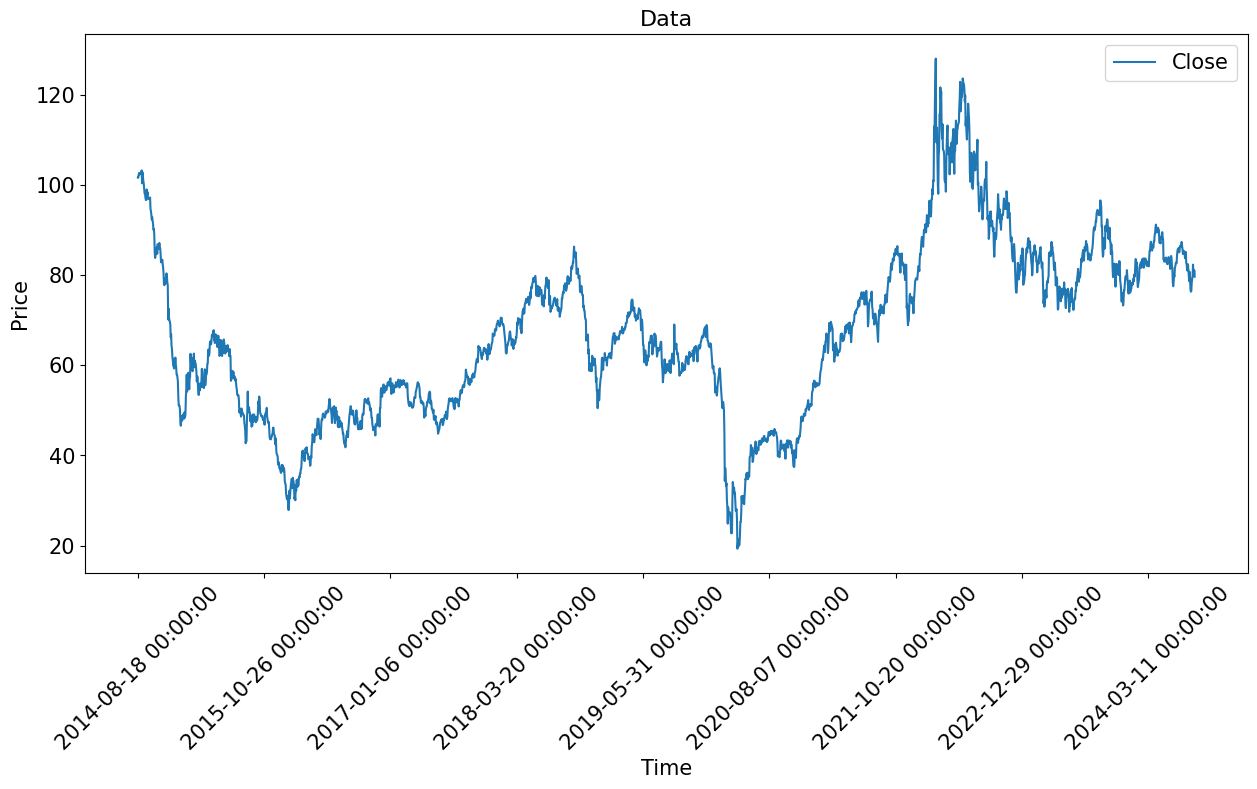

In [ ]:
# Transform index type from datetime to string
forex_data_1['dates'] = forex_data_1.index.strftime(
    '%Y-%m-%d %H:%M:%S')

# Plot the series
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(forex_data_1['dates'], forex_data_1['Close'])

# Set title and axis label
plt.title('Data', fontsize=16)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['Close'], prop={'size': 15})

# Set maximum number of tick locators
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [ ]:
forex_data_2 = yf.download('NG=F', period=period, interval=interval)

# Set the index to a datetime object
forex_data_2.index = pd.to_datetime(forex_data_2.index)

# Display the last five rows
forex_data_2.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-08-12,2.173,2.256,2.155,2.189,2.189,181250
2024-08-13,2.175,2.239,2.134,2.148,2.148,202099
2024-08-14,2.160,2.276,2.144,2.219,2.219,189925
2024-08-15,2.228,2.301,2.189,2.197,2.197,165423
2024-08-16,2.205,2.216,2.111,2.129,2.129,126675


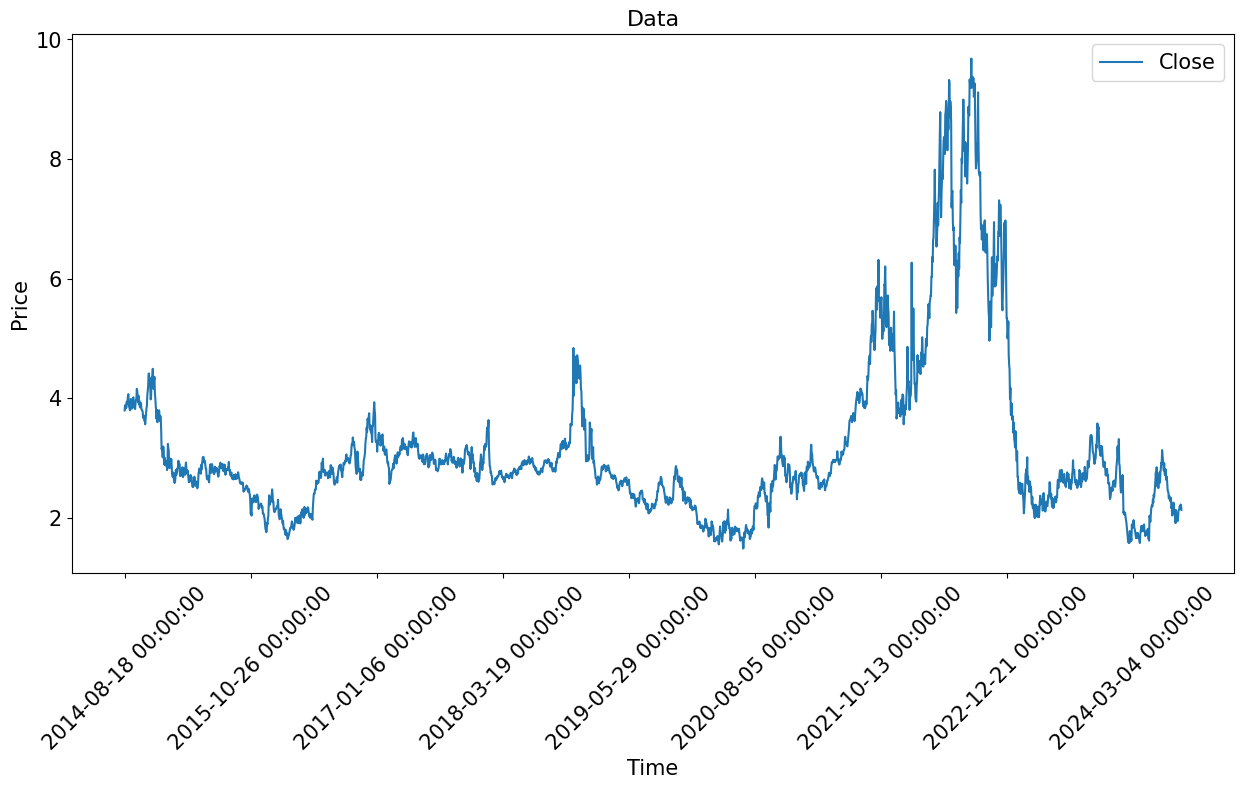

In [ ]:
# Transform index type from datetime to string
forex_data_2['dates'] = forex_data_2.index.strftime(
    '%Y-%m-%d %H:%M:%S')

# Plot the series
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(forex_data_2['dates'], forex_data_2['Close'])

# Set title and axis label
plt.title('Data', fontsize=16)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['Close'], prop={'size': 15})

# Set maximum number of tick locators
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [ ]:
!pip install apimoex

In [ ]:
import requests
import apimoex

session = requests.Session()

In [ ]:
data = apimoex.get_board_history(session, 'MOEX')
forex_data_3 = pd.DataFrame(data)



forex_data_3.set_index('TRADEDATE', inplace=True)
# Display the last five rows
forex_data_3.tail()

,BOARDID,CLOSE,VOLUME,VALUE
TRADEDATE,,,,
2024-08-12,TQBR,228.43,2981460,674477676.3
2024-08-13,TQBR,226.45,3849320,872596411.1
2024-08-14,TQBR,223.54,3511550,789418347.8
2024-08-15,TQBR,223.79,3623770,809580488.8
2024-08-16,TQBR,221.16,2507200,558765175.4


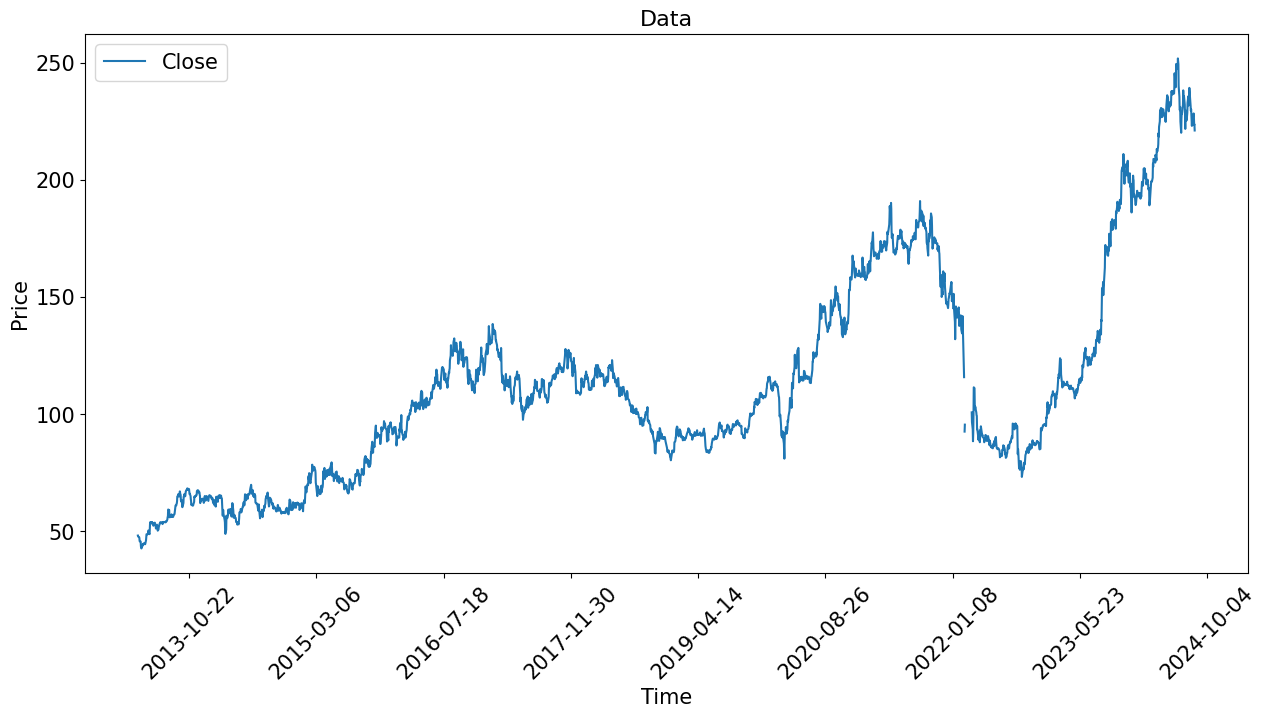

In [ ]:
# Transform index type from datetime to string


forex_data_3.index = forex_data_3.index.astype('datetime64[ns]')

# Plot the series
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(forex_data_3.index, forex_data_3['CLOSE'])

# Set title and axis label
plt.title('Data', fontsize=16)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['Close'], prop={'size': 15})

# Set maximum number of tick locators
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation=45)

# Show the plot
plt.show()

#Add the stock price we are interested in

In [ ]:
Name = 'SBER'

In [ ]:
data = apimoex.get_board_history(session, Name)
forex_data_4 = pd.DataFrame(data)



forex_data_4.set_index('TRADEDATE', inplace=True)
# Display the last five rows
forex_data_4.tail()

,BOARDID,CLOSE,VOLUME,VALUE
TRADEDATE,,,,
2024-08-12,TQBR,280.74,27767330,7.768908e+09
2024-08-13,TQBR,283.92,24058790,6.791088e+09
2024-08-14,TQBR,280.32,21757040,6.148974e+09
2024-08-15,TQBR,278.01,28665290,7.984061e+09
2024-08-16,TQBR,274.60,26195850,7.255848e+09


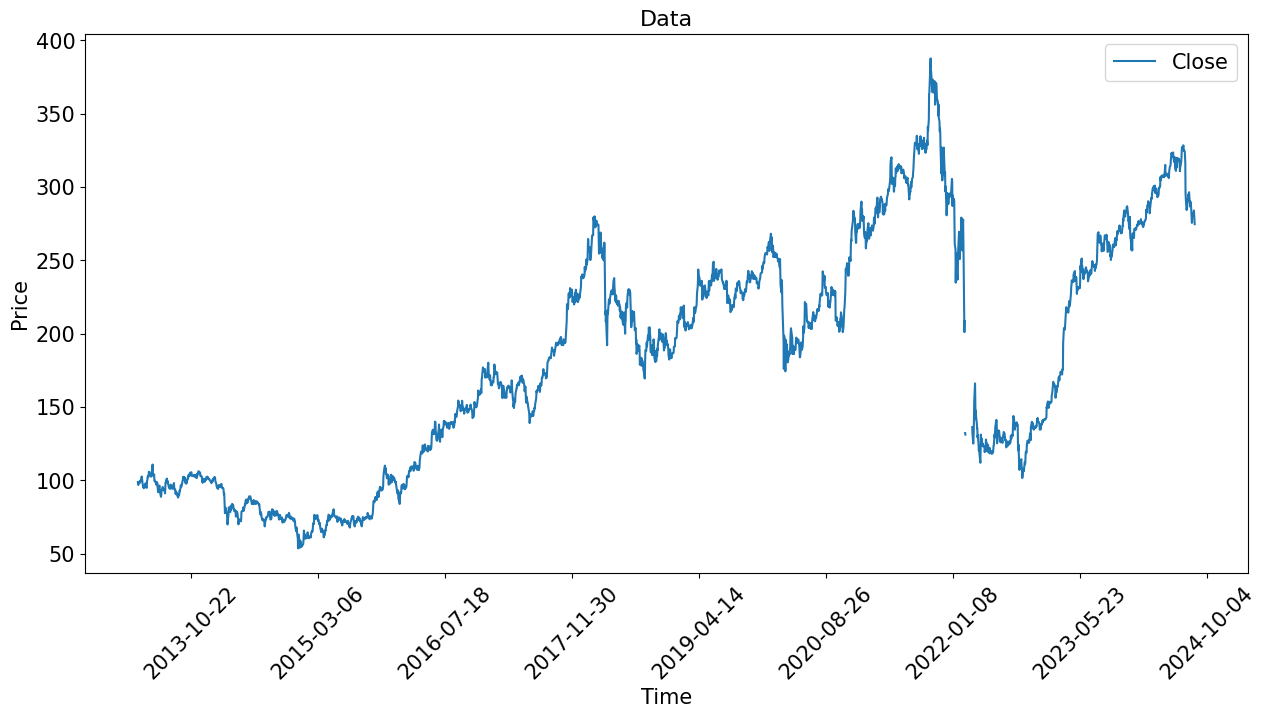

In [ ]:
# Transform index type from datetime to string


forex_data_4.index = forex_data_4.index.astype('datetime64[ns]')

# Plot the series
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(forex_data_4.index, forex_data_4['CLOSE'])

# Set title and axis label
plt.title('Data', fontsize=16)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(['Close'], prop={'size': 15})

# Set maximum number of tick locators
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [ ]:
def display(data, pred = None, vert = None, title = 'Prediction'):
  data = np.array(data).reshape((len(data), 1))
  plt.figure(figsize=(12, 6))
  plt.plot(data, label='Some periodic function')
  if pred != None:
    plt.plot(pred, label=title)
  if vert != None:
    plt.axvline(x=vert, c='r', linestyle='--')
  plt.legend()
  plt.grid()
  plt.show()

In [ ]:
df1 = forex_data[['Close']].rename(columns={'Close': 'dollar'})
df2 = forex_data_1[['Close']].rename(columns={'Close': 'oil'})
df3 = forex_data_2[['Close']].rename(columns={'Close': 'gas'})
df4 = forex_data_3[['CLOSE']].rename(columns={'CLOSE': 'MOEX'})
df5 = forex_data_4[['CLOSE']].rename(columns={'CLOSE': Name})
df = pd.merge(df1,df2, how='inner', left_index=True, right_index=True)
df = pd.merge(df,df3, how='inner', left_index=True, right_index=True)
df = pd.merge(df,df4, how='inner', left_index=True, right_index=True)
df = pd.merge(df,df5, how='inner', left_index=True, right_index=True)
df

,dollar,oil,gas,MOEX,SBER
2014-08-18,36.051201,101.599998,3.792,61.80,75.15
2014-08-19,36.013100,101.559998,3.877,63.80,76.00
2014-08-20,36.141201,102.279999,3.823,64.00,76.90
2014-08-21,36.146702,102.629997,3.889,64.99,78.40
2014-08-22,35.960300,102.290001,3.840,64.25,78.39
...,...,...,...,...,...
2024-08-12,86.799545,82.300003,2.189,228.43,280.74
2024-08-13,90.995522,80.690002,2.148,226.45,283.92
2024-08-14,90.496338,79.760002,2.219,223.54,280.32
2024-08-15,89.795135,81.040001,2.197,223.79,278.01


In [ ]:
df = df.dropna()
df

,dollar,oil,gas,MOEX,SBER
2014-08-18,36.051201,101.599998,3.792,61.80,75.15
2014-08-19,36.013100,101.559998,3.877,63.80,76.00
2014-08-20,36.141201,102.279999,3.823,64.00,76.90
2014-08-21,36.146702,102.629997,3.889,64.99,78.40
2014-08-22,35.960300,102.290001,3.840,64.25,78.39
...,...,...,...,...,...
2024-08-12,86.799545,82.300003,2.189,228.43,280.74
2024-08-13,90.995522,80.690002,2.148,226.45,283.92
2024-08-14,90.496338,79.760002,2.219,223.54,280.32
2024-08-15,89.795135,81.040001,2.197,223.79,278.01


Let's predict last 20 days.

In [ ]:
train_size = int(len(df)-20)

train_data = df[:train_size].to_numpy()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler()
train_df = scaler1.fit_transform(train_data)


In [ ]:
input_size = 5
hidden_size = 40
num_classes = 5


In [ ]:
set_random_seed(42)
import warnings
warnings.filterwarnings('ignore')

# create data "ensemble"
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length):
        _x = data[i:(i + seq_length)] # picking several sequential observations
        _y = data[i+seq_length] # picking the subsequent observation
        x.append(_x)
        y.append(_y)

    return torch.Tensor(np.array(x)), torch.Tensor(np.array(y))

# set length of the ensemble; accuracy of the predictions and
# speed perfomance almost always depend on it size
seq_length =  40 # compare 2 and 32
x, y = sliding_windows(train_df, seq_length)
print("Example of the obtained data:\n")
print("Data corresponding to the first x:")
print(x[0])
print("Data corresponding to the first y:")
print(y[0])


x_train = x
y_train = y




# Define new LSTM based model
class LSTMPredictor(nn.Module):

    def __init__(self, input_size, hidden_size, num_classes):
        # hidden_size == number of neurons
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, dropout=0.2)
        self.lstm2 = nn.LSTM(input_size=input_size, hidden_size=hidden_size//2, batch_first=True, dropout=0.2)
        self.lstm3 = nn.LSTM(input_size=input_size, hidden_size=hidden_size//4, batch_first=True, dropout=0.2)
        self.lstm4 = nn.LSTM(input_size=input_size, hidden_size=hidden_size//8, batch_first=True, dropout=0.2)
        self.fc_1 = nn.Linear(input_size*hidden_size, 64) # fully connected
        self.fc_11 = nn.Linear(64, 64)
        self.a = hidden_size + hidden_size//2 + hidden_size//4 + hidden_size//8
        self.fc_2 = nn.Linear(self.a, 1) # fully connected
        self.fc_3 = nn.Linear(self.a, 1) # fully connected
        self.fc_4 = nn.Linear(self.a, 1) # fully connected
        self.fc_5 = nn.Linear(self.a, 1) # fully connected
        self.fc_6 = nn.Linear(self.a, 1) # fully connected
        self.relu = nn.Tanh()
        self.drop = nn.Dropout(p=0.2)

    def forward(self, x):
        out, (h1, c) = self.lstm1(x)
        out, (h2, c) = self.lstm2(x)
        out, (h3, c) = self.lstm3(x)
        out, (h4, c) = self.lstm4(x)

        out1 = torch.cat((h1, h2, h3, h4), 2)
        #out1 = self.drop(self.fc_11(self.drop(self.fc_1(self.relu(out)))))
        out2 = self.fc_2(self.relu(out1))
        out3 = self.fc_3(self.relu(out1))
        out4 = self.fc_4(self.relu(out1))
        out5 = self.fc_5(self.relu(out1))
        out6 = self.fc_6(self.relu(out1))

        return torch.cat((out2, out3, out4, out5, out6), 2)

lstm =  LSTMPredictor(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)


lstm.train()

print("LSTM training process with MAE loss:")

num_epochs = 4000
learning_rate = 0.001

criterion = torch.nn.L1Loss()
optimizer = torch.optim.AdamW(lstm.parameters(), lr=learning_rate)

 # Train the model
for epoch in range(num_epochs):
    y_pred = lstm(x_train)
    optimizer.zero_grad()
    #print(outputs.shape)
    loss = criterion(y_pred, y_train.unsqueeze(0))
    loss.backward()

    optimizer.step()
    if epoch % 200 == 0:
        print(f"Epoch: {epoch},".ljust(15), "loss: %1.5f" % (loss.item()))

Example of the obtained data:

Data corresponding to the first x:
tensor([[0.3481, 0.7892, 0.2818, 0.0236, 0.0648],
        [0.3478, 0.7888, 0.2921, 0.0339, 0.0673],
        [0.3490, 0.7957, 0.2856, 0.0349, 0.0700],
        [0.3491, 0.7990, 0.2936, 0.0400, 0.0745],
        [0.3472, 0.7958, 0.2876, 0.0362, 0.0745],
        [0.3481, 0.7992, 0.2995, 0.0397, 0.0750],
        [0.3480, 0.7978, 0.2963, 0.0462, 0.0717],
        [0.3476, 0.7999, 0.3019, 0.0478, 0.0731],
        [0.3488, 0.7974, 0.3125, 0.0385, 0.0631],
        [0.3537, 0.8044, 0.3151, 0.0324, 0.0590],
        [0.3603, 0.7771, 0.2937, 0.0186, 0.0606],
        [0.3617, 0.8004, 0.2885, 0.0318, 0.0748],
        [0.3552, 0.7914, 0.2851, 0.0365, 0.0775],
        [0.3562, 0.7817, 0.2819, 0.0360, 0.0801],
        [0.3565, 0.7757, 0.2920, 0.0341, 0.0754],
        [0.3568, 0.7658, 0.3052, 0.0304, 0.0776],
        [0.3578, 0.7550, 0.3015, 0.0313, 0.0753],
        [0.3602, 0.7554, 0.2856, 0.0255, 0.0682],
        [0.3614, 0.7461, 0.2897, 0

Check memory

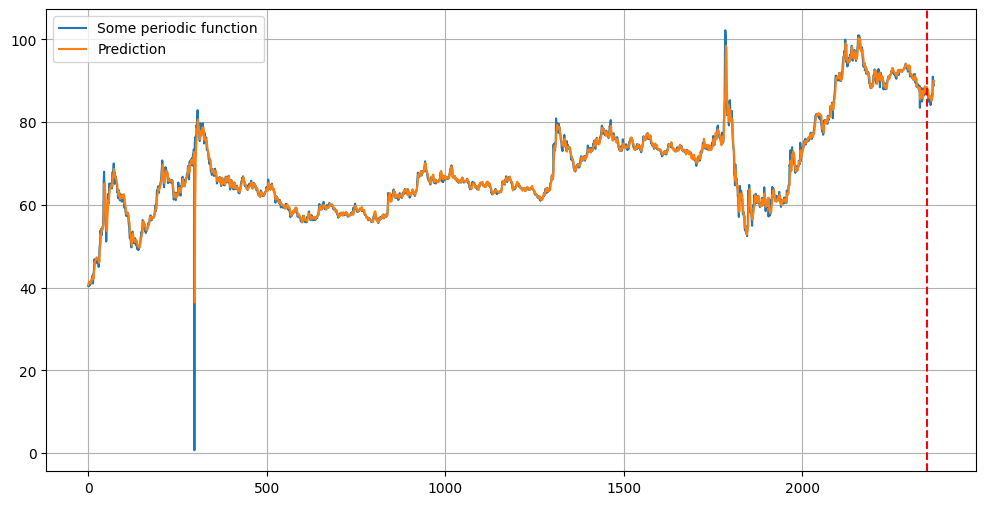

In [ ]:
x_s, y_s = sliding_windows(scaler1.transform(df.to_numpy().reshape(-1,num_classes)), seq_length)

lstm.eval()

train_predict = lstm(x_s)
display(data=df[seq_length:len(df)].to_numpy().reshape(-1,num_classes)[:,0], pred=list(scaler1.inverse_transform(train_predict.detach().numpy().reshape(-1,num_classes)).reshape(-1,num_classes)[:,0]), vert=train_size-seq_length+1)

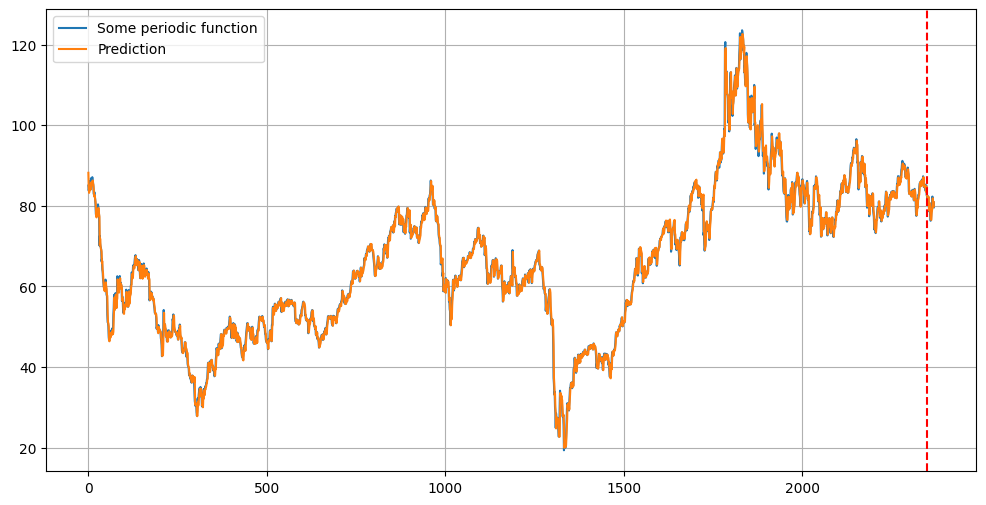

In [ ]:
x_s, y_s = sliding_windows(scaler1.transform(df.to_numpy().reshape(-1,num_classes)), seq_length)

lstm.eval()

train_predict = lstm(x_s)
display(data=df[seq_length:len(df)].to_numpy().reshape(-1,num_classes)[:,1], pred=list(scaler1.inverse_transform(train_predict.detach().numpy().reshape(-1,num_classes)).reshape(-1,num_classes)[:,1]), vert=train_size-seq_length+1)

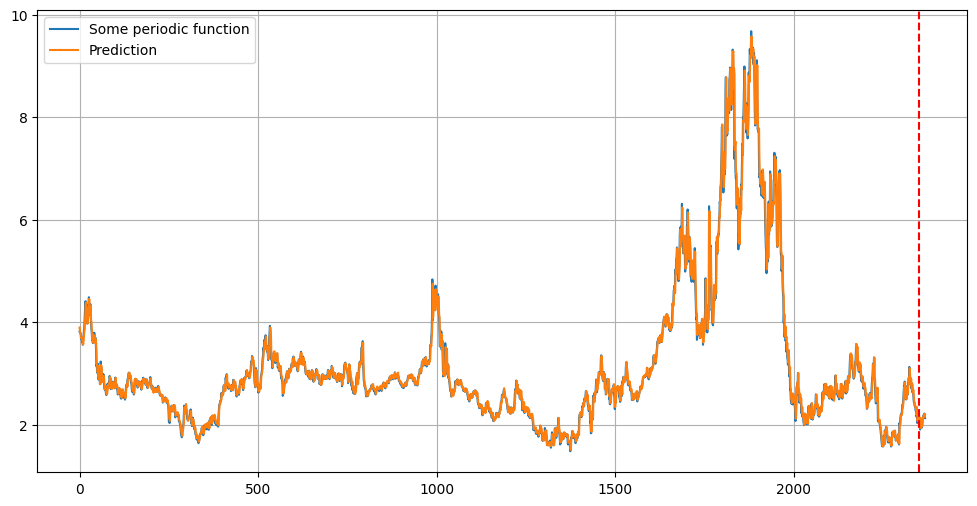

In [ ]:
x_s, y_s = sliding_windows(scaler1.transform(df.to_numpy().reshape(-1,num_classes)), seq_length)

lstm.eval()

train_predict = lstm(x_s)
display(data=df[seq_length:len(df)].to_numpy().reshape(-1,num_classes)[:,2], pred=list(scaler1.inverse_transform(train_predict.detach().numpy().reshape(-1,num_classes)).reshape(-1,num_classes)[:,2]), vert=train_size-seq_length+1)

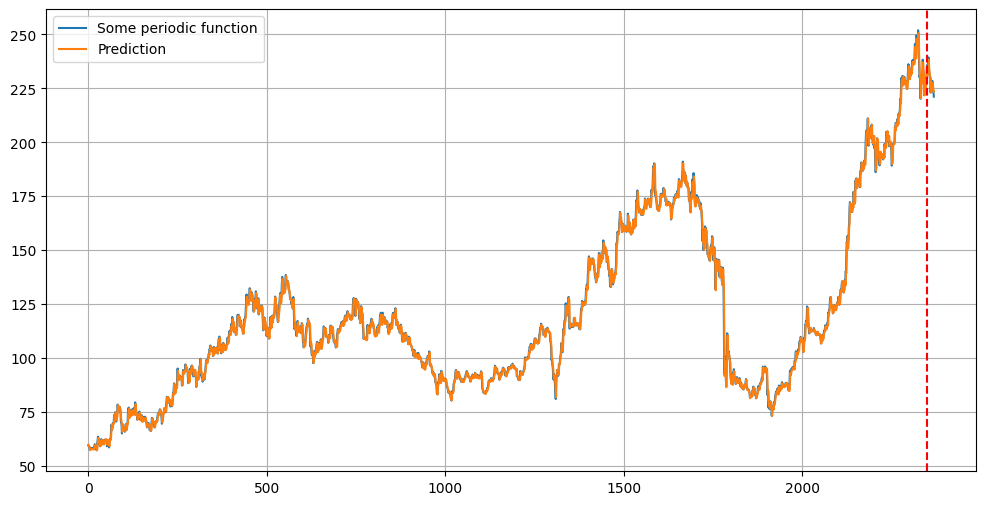

In [ ]:
x_s, y_s = sliding_windows(scaler1.transform(df.to_numpy().reshape(-1,num_classes)), seq_length)

lstm.eval()

train_predict = lstm(x_s)
display(data=df[seq_length:len(df)].to_numpy().reshape(-1,num_classes)[:,3], pred=list(scaler1.inverse_transform(train_predict.detach().numpy().reshape(-1,num_classes)).reshape(-1,num_classes)[:,3]), vert=train_size-seq_length+1)

In [ ]:
data_pred = scaler1.transform(df[:train_size].to_numpy().reshape(-1,num_classes))

x_s, y_s = sliding_windows(data_pred, seq_length)
for i in range(20):
    data_pred = np.append(data_pred, (lstm(x_s).detach().numpy()[0][-1]).reshape(-1,num_classes),  axis=0)
    x_s, y_s = sliding_windows(data_pred, seq_length)
data_pred

array([[0.34813222, 0.78916064, 0.28177604, 0.02362124, 0.06480096],
       [0.34775683, 0.78877694, 0.29214443, 0.03389134, 0.06734511],
       [0.34901893, 0.79568343, 0.28555744, 0.03491835, 0.07003891],
       ...,
       [0.87126273, 0.59234875, 0.07076401, 0.88167912, 0.71580565],
       [0.86792475, 0.61714721, 0.09144247, 0.8616544 , 0.70885241],
       [0.87209672, 0.59094769, 0.07033292, 0.87989718, 0.71625853]])

In [ ]:
df[-20:]

,dollar,oil,gas,MOEX,SBER
2024-07-22,86.884720,82.400002,2.251,235.77,294.71
2024-07-23,87.844658,81.010002,2.187,231.85,294.39
2024-07-24,87.845520,81.709999,2.117,232.32,295.69
2024-07-25,86.236908,82.370003,2.041,232.16,296.37
2024-07-26,84.994286,81.129997,2.006,239.36,293.30
2024-07-29,84.995621,79.779999,1.907,234.94,286.58
2024-07-30,86.395805,78.629997,2.126,233.12,290.00
2024-07-31,85.747467,80.720001,2.036,231.71,289.30
2024-08-01,85.996269,79.519997,1.968,229.60,287.21
2024-08-02,85.514488,76.809998,1.967,230.25,286.04


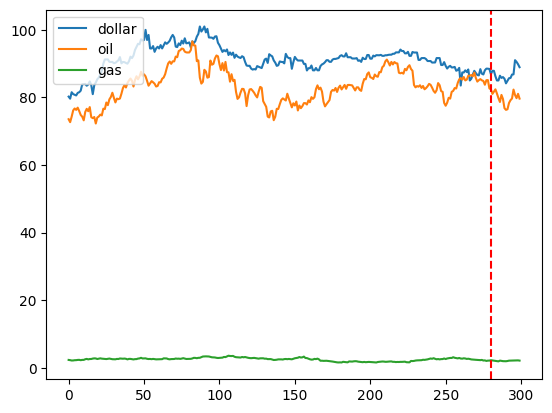

In [ ]:
plt.plot(df.to_numpy()[-300:,0:3])
plt.legend(['dollar','oil','gas'], loc=2)
plt.axvline(x=280, c='r', linestyle='--')

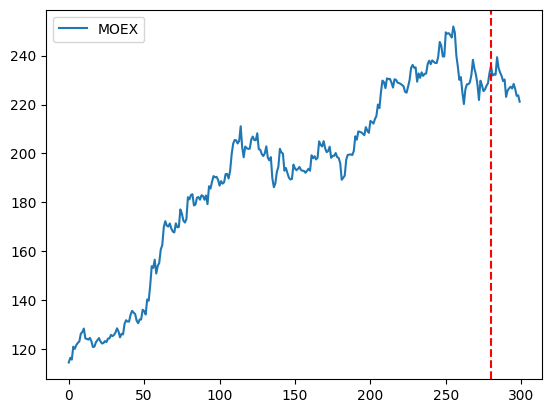

In [ ]:
plt.plot(df.to_numpy()[-300:,3])
plt.legend(['MOEX'], loc=2)
plt.axvline(x=280, c='r', linestyle='--')

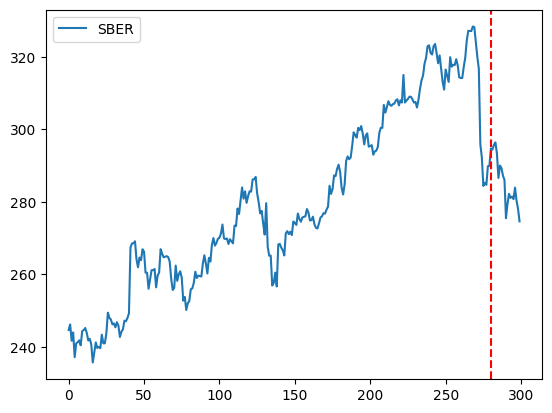

In [ ]:
plt.plot(df.to_numpy()[-300:,4])
plt.legend([Name], loc=2)
plt.axvline(x=280, c='r', linestyle='--')

Predicted data

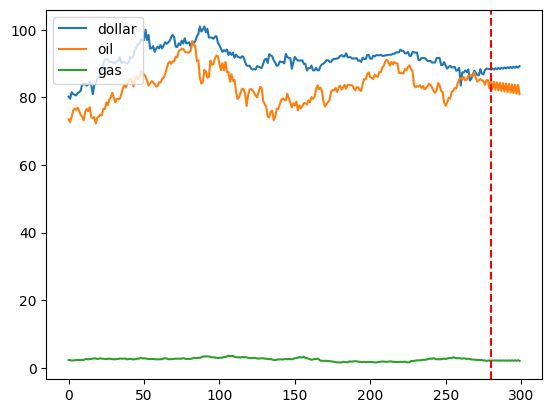

In [ ]:
plt.plot(scaler1.inverse_transform(data_pred.reshape(-1,num_classes))[-300:,0:3])
plt.legend(['dollar','oil','gas'], loc=2)
plt.axvline(x=280, c='r', linestyle='--')

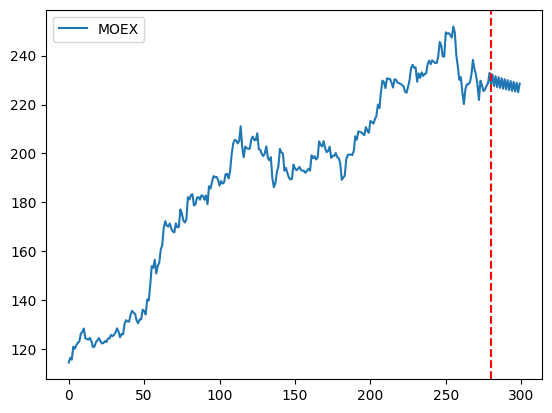

In [ ]:
plt.plot(scaler1.inverse_transform(data_pred.reshape(-1,num_classes))[-300:,3])
plt.legend(['MOEX'], loc=2)
plt.axvline(x=280, c='r', linestyle='--')

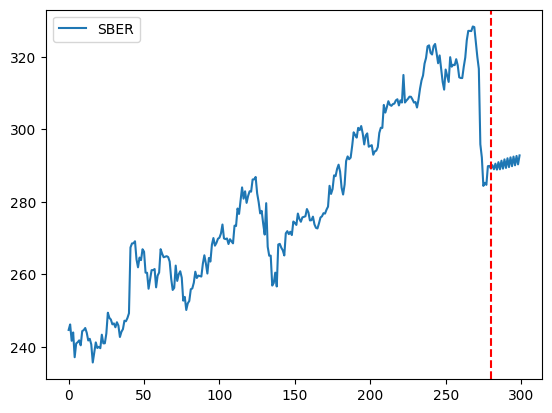

In [ ]:
plt.plot(scaler1.inverse_transform(data_pred.reshape(-1,num_classes))[-300:,4])
plt.legend([Name], loc=2)
plt.axvline(x=280, c='r', linestyle='--')

In [ ]:
train_size = int(len(df))

train_data = df[:train_size].to_numpy()
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler()
train_df = scaler1.fit_transform(train_data)


set_random_seed(42)
import warnings
warnings.filterwarnings('ignore')

# create data "ensemble"
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length):
        _x = data[i:(i + seq_length)] # picking several sequential observations
        _y = data[i+seq_length] # picking the subsequent observation
        x.append(_x)
        y.append(_y)

    return torch.Tensor(np.array(x)), torch.Tensor(np.array(y))

# set length of the ensemble; accuracy of the predictions and
# speed perfomance almost always depend on it size
seq_length = 40 # compare 2 and 32
x, y = sliding_windows(train_df, seq_length)
print("Example of the obtained data:\n")
print("Data corresponding to the first x:")
print(x[0])
print("Data corresponding to the first y:")
print(y[0])


x_train = x
y_train = y




# Define new LSTM based model
class LSTMPredictor(nn.Module):

    def __init__(self, input_size, hidden_size, num_classes):
        # hidden_size == number of neurons
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, dropout=0.2)
        self.lstm2 = nn.LSTM(input_size=input_size, hidden_size=hidden_size//2, batch_first=True, dropout=0.2)
        self.lstm3 = nn.LSTM(input_size=input_size, hidden_size=hidden_size//4, batch_first=True, dropout=0.2)
        self.lstm4 = nn.LSTM(input_size=input_size, hidden_size=hidden_size//8, batch_first=True, dropout=0.2)
        self.fc_1 = nn.Linear(4*hidden_size, 64) # fully connected
        self.fc_11 = nn.Linear(64, 64)
        self.a = hidden_size + hidden_size//2 + hidden_size//4 + hidden_size//8
        self.fc_2 = nn.Linear(self.a, 1) # fully connected
        self.fc_3 = nn.Linear(self.a, 1) # fully connected
        self.fc_4 = nn.Linear(self.a, 1) # fully connected
        self.fc_5 = nn.Linear(self.a, 1) # fully connected
        self.fc_6 = nn.Linear(self.a, 1) # fully connected
        self.relu = nn.Tanh()
        self.drop = nn.Dropout(p=0.2)

    def forward(self, x):
        out, (h1, c) = self.lstm1(x)
        out, (h2, c) = self.lstm2(x)
        out, (h3, c) = self.lstm3(x)
        out, (h4, c) = self.lstm4(x)

        out1 = torch.cat((h1, h2, h3, h4), 2)
        #out1 = self.drop(self.fc_11(self.drop(self.fc_1(self.relu(out)))))
        out2 = self.fc_2(self.relu(out1))
        out3 = self.fc_3(self.relu(out1))
        out4 = self.fc_4(self.relu(out1))
        out5 = self.fc_5(self.relu(out1))
        out6 = self.fc_6(self.relu(out1))

        return torch.cat((out2, out3, out4, out5, out6), 2)

lstm =  LSTMPredictor(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)

lstm.train()

print("LSTM training process with MAE loss:")

num_epochs = 4000
learning_rate = 0.001

criterion = torch.nn.L1Loss()
optimizer = torch.optim.AdamW(lstm.parameters(), lr=learning_rate)

 # Train the model
for epoch in range(num_epochs):
    y_pred = lstm(x_train)
    optimizer.zero_grad()
    #print(outputs.shape)
    loss = criterion(y_pred, y_train.unsqueeze(0))
    loss.backward()

    optimizer.step()
    if epoch % 200 == 0:
        print(f"Epoch: {epoch},".ljust(15), "loss: %1.5f" % (loss.item()))

Example of the obtained data:

Data corresponding to the first x:
tensor([[0.3481, 0.7892, 0.2818, 0.0236, 0.0648],
        [0.3478, 0.7888, 0.2921, 0.0339, 0.0673],
        [0.3490, 0.7957, 0.2856, 0.0349, 0.0700],
        [0.3491, 0.7990, 0.2936, 0.0400, 0.0745],
        [0.3472, 0.7958, 0.2876, 0.0362, 0.0745],
        [0.3481, 0.7992, 0.2995, 0.0397, 0.0750],
        [0.3480, 0.7978, 0.2963, 0.0462, 0.0717],
        [0.3476, 0.7999, 0.3019, 0.0478, 0.0731],
        [0.3488, 0.7974, 0.3125, 0.0385, 0.0631],
        [0.3537, 0.8044, 0.3151, 0.0324, 0.0590],
        [0.3603, 0.7771, 0.2937, 0.0186, 0.0606],
        [0.3617, 0.8004, 0.2885, 0.0318, 0.0748],
        [0.3552, 0.7914, 0.2851, 0.0365, 0.0775],
        [0.3562, 0.7817, 0.2819, 0.0360, 0.0801],
        [0.3565, 0.7757, 0.2920, 0.0341, 0.0754],
        [0.3568, 0.7658, 0.3052, 0.0304, 0.0776],
        [0.3578, 0.7550, 0.3015, 0.0313, 0.0753],
        [0.3602, 0.7554, 0.2856, 0.0255, 0.0682],
        [0.3614, 0.7461, 0.2897, 0

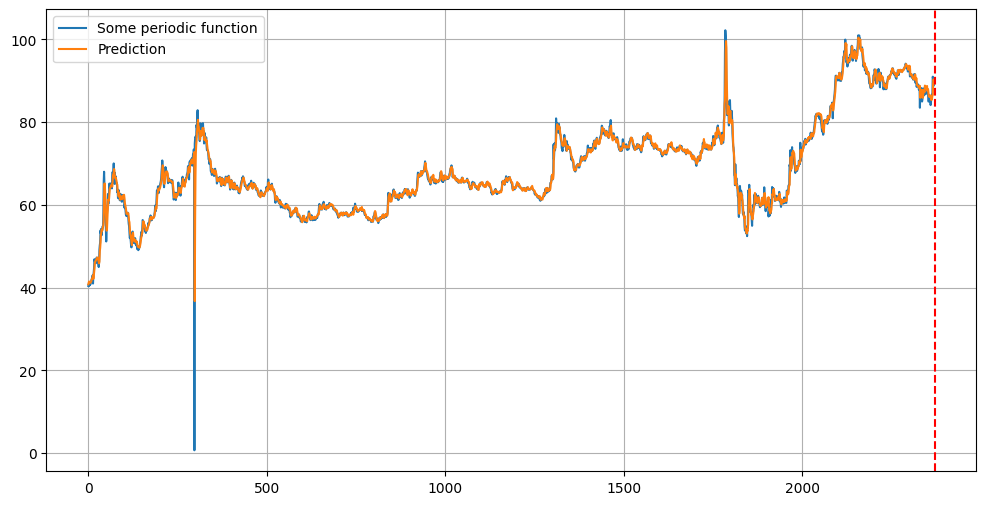

In [ ]:
x_s, y_s = sliding_windows(scaler1.transform(df.to_numpy().reshape(-1,num_classes)), seq_length)

lstm.eval()

train_predict = lstm(x_s)
display(data=df[seq_length:len(df)].to_numpy().reshape(-1,num_classes)[:,0], pred=list(scaler1.inverse_transform(train_predict.detach().numpy().reshape(-1,num_classes)).reshape(-1,num_classes)[:,0]), vert=train_size-seq_length+1)

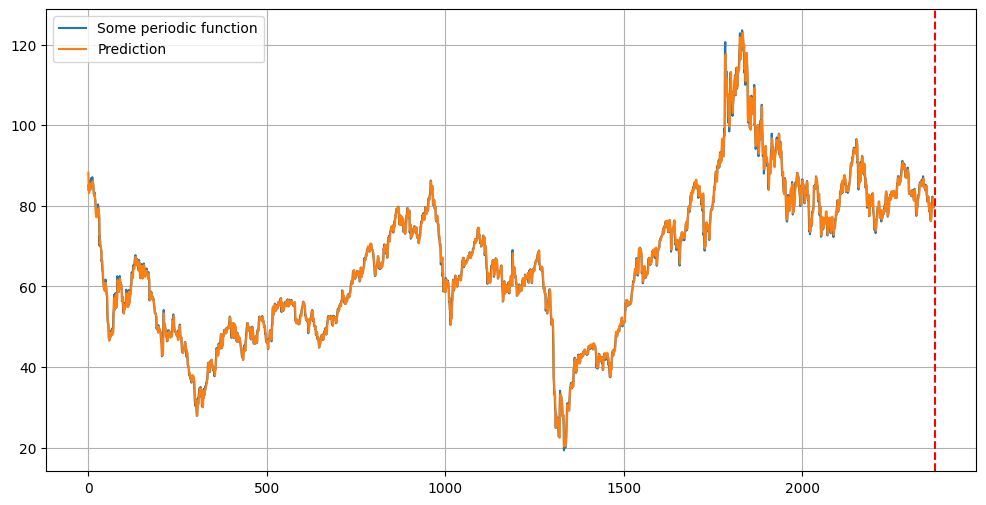

In [ ]:
x_s, y_s = sliding_windows(scaler1.transform(df.to_numpy().reshape(-1,num_classes)), seq_length)

lstm.eval()

train_predict = lstm(x_s)
display(data=df[seq_length:len(df)].to_numpy().reshape(-1,num_classes)[:,1], pred=list(scaler1.inverse_transform(train_predict.detach().numpy().reshape(-1,num_classes)).reshape(-1,num_classes)[:,1]), vert=train_size-seq_length+1)

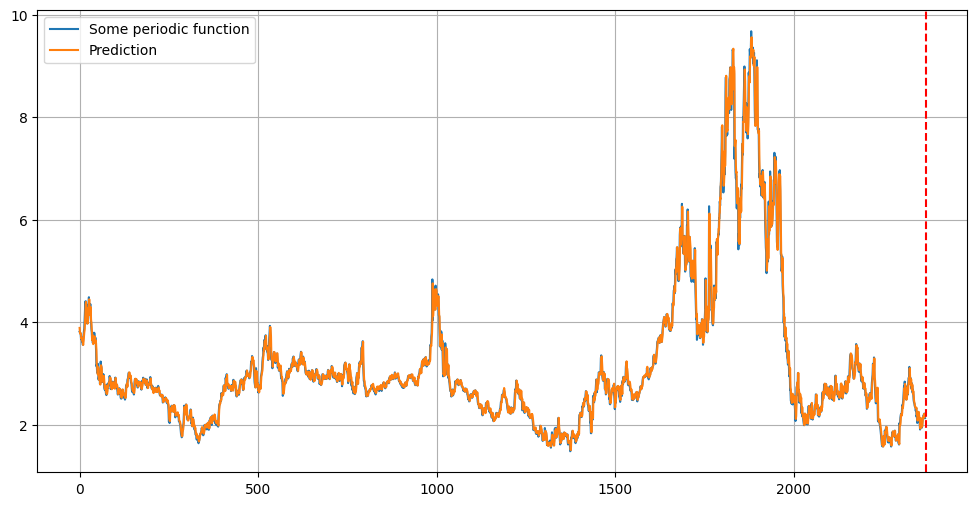

In [ ]:
x_s, y_s = sliding_windows(scaler1.transform(df.to_numpy().reshape(-1,num_classes)), seq_length)

lstm.eval()

train_predict = lstm(x_s)
display(data=df[seq_length:len(df)].to_numpy().reshape(-1,num_classes)[:,2], pred=list(scaler1.inverse_transform(train_predict.detach().numpy().reshape(-1,num_classes)).reshape(-1,num_classes)[:,2]), vert=train_size-seq_length+1)

In [ ]:
data_pred = scaler1.transform(df.to_numpy().reshape(-1,num_classes))

x_s, y_s = sliding_windows(data_pred, seq_length)
for i in range(20):
    data_pred = np.append(data_pred, (lstm(x_s).detach().numpy()[0][-1]).reshape(-1,num_classes),  axis=0)
    x_s, y_s = sliding_windows(data_pred, seq_length)
data_pred

array([[0.34813222, 0.78916064, 0.28177604, 0.02362124, 0.06480096],
       [0.34775683, 0.78877694, 0.29214443, 0.03389134, 0.06734511],
       [0.34901893, 0.79568343, 0.28555744, 0.03491835, 0.07003891],
       ...,
       [0.89032823, 0.58138812, 0.08305115, 0.82505977, 0.67159075],
       [0.8830502 , 0.59616899, 0.09422225, 0.83327103, 0.68226248],
       [0.8913343 , 0.58177316, 0.08360654, 0.8232711 , 0.67209417]])

In [ ]:
pd.DataFrame(scaler1.inverse_transform(data_pred.reshape(-1,num_classes))[-(20):-1])

,0,1,2,3,4
0,90.157153,80.910889,2.200684,223.506539,279.843832
1,89.917568,79.647086,2.126876,220.954812,275.852885
2,89.770310,81.051632,2.204892,223.067059,279.659847
3,90.259715,79.651113,2.127562,220.583410,276.392731
4,89.710254,81.097210,2.212644,222.561916,279.935993
5,90.419738,79.693224,2.132443,220.184603,276.658044
6,89.756238,81.164219,2.220855,222.060464,280.223431
7,90.545005,79.744692,2.138057,219.777717,276.880204
8,89.841529,81.225251,2.227942,221.575785,280.485498
9,90.659661,79.786660,2.143375,219.375114,277.099635


In [ ]:
df_pred = scaler1.inverse_transform(data_pred.reshape(-1,num_classes))
df_pred

array([[ 36.05120087, 101.59999847,   3.79200006,  61.8       ,
         75.15      ],
       [ 36.01309967, 101.55999756,   3.87700009,  63.8       ,
         76.        ],
       [ 36.14120102, 102.27999878,   3.82299995,  64.        ,
         76.9       ],
       ...,
       [ 91.08344354,  79.93971211,   2.16285331, 217.87213991,
        277.87846805],
       [ 90.34473274,  81.48061878,   2.25443401, 219.47119972,
        281.44389465],
       [ 91.1855581 ,  79.97985316,   2.16740644, 217.52381319,
        278.04666095]])

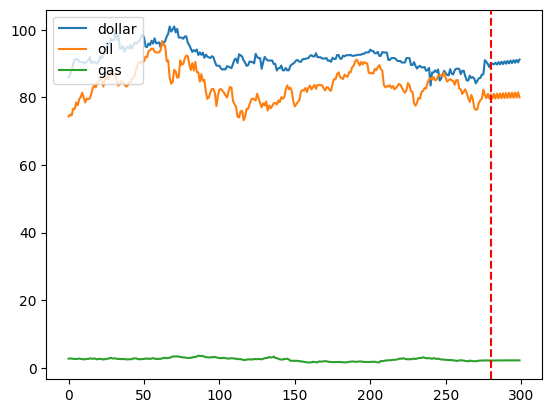

In [ ]:
plt.plot(df_pred[-300:,0:3])
plt.legend(['dollar','oil','gas'], loc=2)
plt.axvline(x=300-20, c='r', linestyle='--')

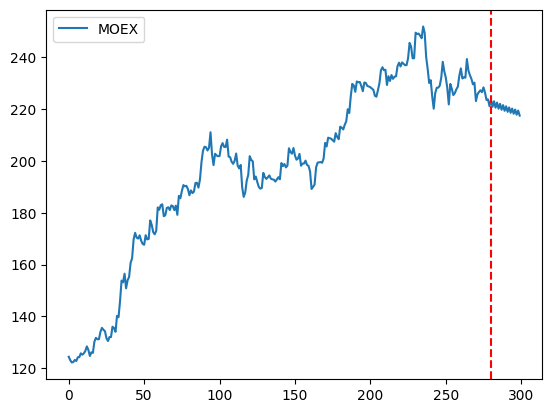

In [ ]:
plt.plot(df_pred[-300:,3])
plt.legend(['MOEX'], loc=2)
plt.axvline(x=280, c='r', linestyle='--')

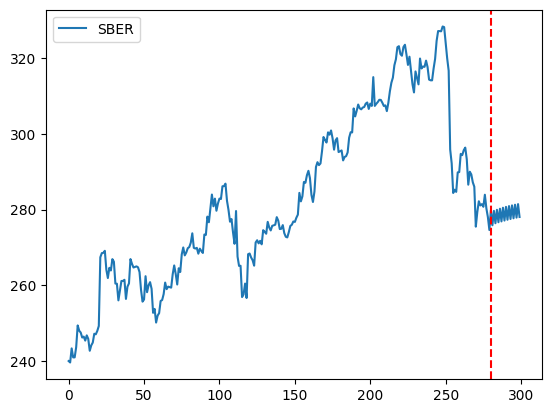

In [ ]:
plt.plot(df_pred[-300:,4])
plt.legend([Name], loc=2)
plt.axvline(x=280, c='r', linestyle='--')